# Brady Hobson, Sara Kent
# DS4420
# Final Project Python - Time Series

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import AutoReg
import warnings
warnings.simplefilter("ignore")


In [2]:
lmp_df = pd.read_csv('lmp_data.csv')
lmp_df.head()

,interval_start_local,interval_start_utc,interval_end_local,interval_end_utc,location,location_type,lmp,energy,congestion,loss
0,2024-01-01T00:00:00-05:00,2024-01-01 05:00:00+00:00,2024-01-01T01:00:00-05:00,2024-01-01 06:00:00+00:00,AR.BEARSWMP13.8BSW1P,NETWORK NODE,51.98,53.36,0.0,-1.38
1,2024-01-01T01:00:00-05:00,2024-01-01 06:00:00+00:00,2024-01-01T02:00:00-05:00,2024-01-01 07:00:00+00:00,AR.BEARSWMP13.8BSW1P,NETWORK NODE,35.07,35.60,0.0,-0.53
2,2024-01-01T02:00:00-05:00,2024-01-01 07:00:00+00:00,2024-01-01T03:00:00-05:00,2024-01-01 08:00:00+00:00,AR.BEARSWMP13.8BSW1P,NETWORK NODE,29.06,29.53,0.0,-0.47
3,2024-01-01T03:00:00-05:00,2024-01-01 08:00:00+00:00,2024-01-01T04:00:00-05:00,2024-01-01 09:00:00+00:00,AR.BEARSWMP13.8BSW1P,NETWORK NODE,28.71,29.13,0.0,-0.42
4,2024-01-01T04:00:00-05:00,2024-01-01 09:00:00+00:00,2024-01-01T05:00:00-05:00,2024-01-01 10:00:00+00:00,AR.BEARSWMP13.8BSW1P,NETWORK NODE,27.67,28.11,0.0,-0.44


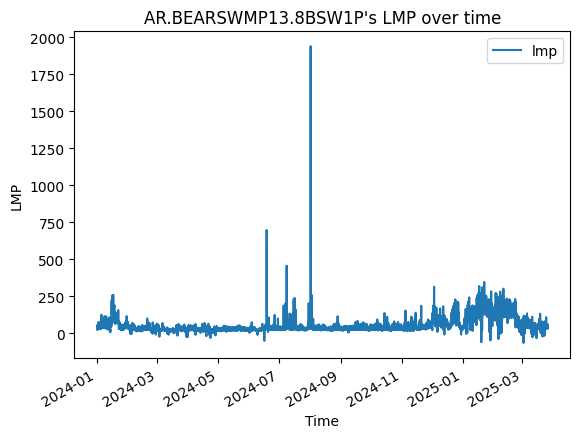

In [3]:
time = pd.to_datetime(lmp_df['interval_start_utc'])
lmp = lmp_df[['interval_start_utc', 'lmp']]
lmp.set_index('interval_start_utc', inplace=True)
lmp.index = pd.to_datetime(lmp.index)

lmp.plot()
plt.xlabel('Time')
plt.ylabel('LMP')
plt.title("AR.BEARSWMP13.8BSW1P's LMP over time")
plt.show()


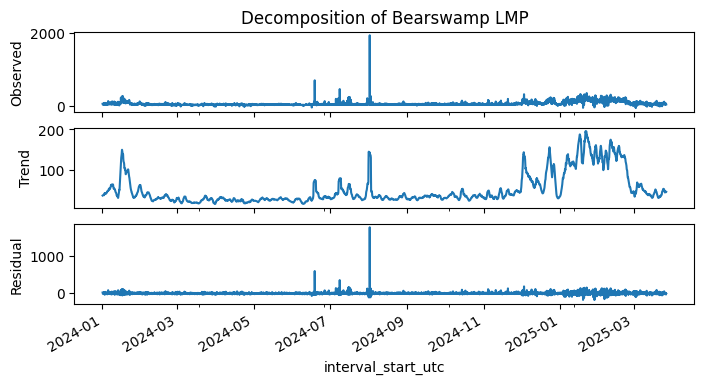

In [8]:
# look at ACF and PACF and seasonality
# visualize the decomp
decomp = seasonal_decompose(lmp['lmp'], period=48, model='additive', extrapolate_trend='freq')

fig, ax = plt.subplots(ncols=1, nrows=3, sharex=True, figsize=(8,4))
ax[0].set_title('Decomposition of Bearswamp LMP')
decomp.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')

decomp.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')

decomp.resid.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Residual')

plt.show();

<AxesSubplot: title={'center': 'Seasonal Component (1 week)'}, xlabel='interval_start_utc'>

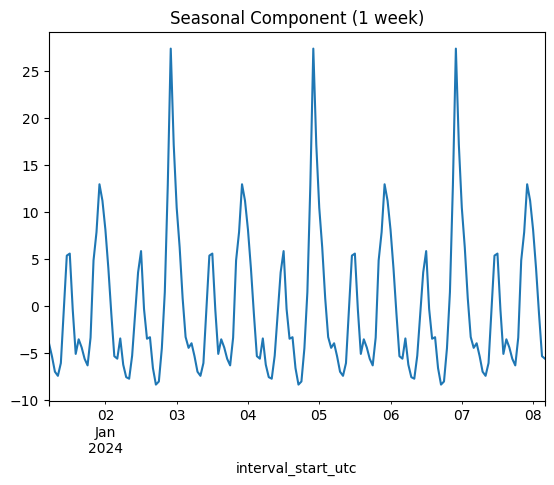

In [9]:
decomp.seasonal.iloc[:24*7].plot(title="Seasonal Component (1 week)")

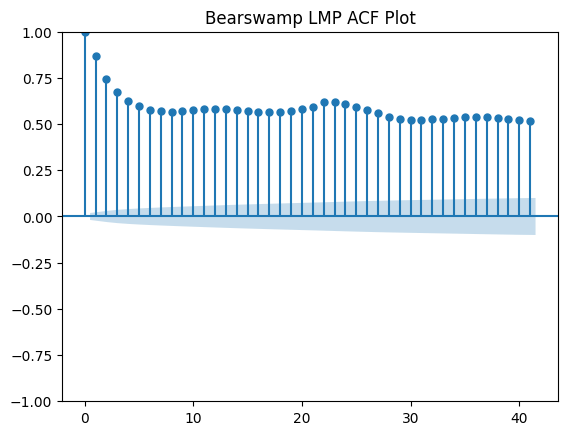

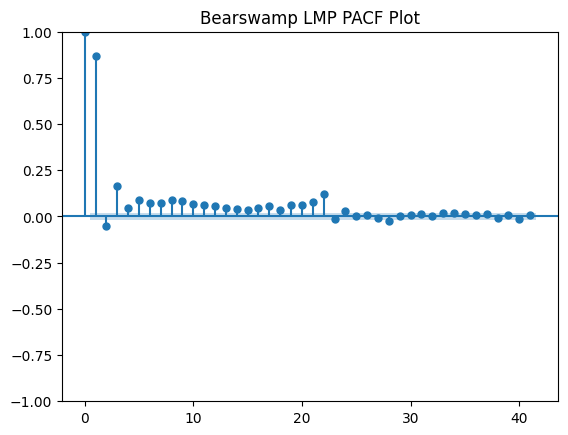

In [5]:
# plot the acf
series = lmp['lmp']
plot_acf(series, title = 'Bearswamp LMP ACF Plot')
plt.show();

# plot the pacf
plot_pacf(series, title='Bearswamp LMP PACF Plot')
plt.show();

AR model would be best since there is high autocorrelation for the first 40 lags

## ARIMA

In [6]:
# split into train and test data 
train_size = int(.8 * len(lmp))
train_data = lmp[:train_size]
test_data = lmp[train_size:]

# ARIMA model
y_train = np.array(train_data['lmp']).reshape(-1,1)
y_test = np.array(test_data['lmp']).reshape(-1,1)
model = ARIMA(y_train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8639
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -39616.712
Date:                Wed, 02 Apr 2025   AIC                          79245.423
Time:                        12:51:22   BIC                          79287.807
Sample:                             0   HQIC                         79259.875
                               - 8639                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0881      0.001    -71.115      0.000      -0.091      -0.086
ar.L2         -0.2961      0.002   -154.802      0.000      -0.300      -0.292
ar.L3         -0.1482      0.002    -84.167      0.0

In [7]:
abs(model_fit.arroots)

array([1.39991778, 1.39991778, 1.59606257, 1.59606257, 1.959223  ])

The roots are >1 so the stationary assumption is met

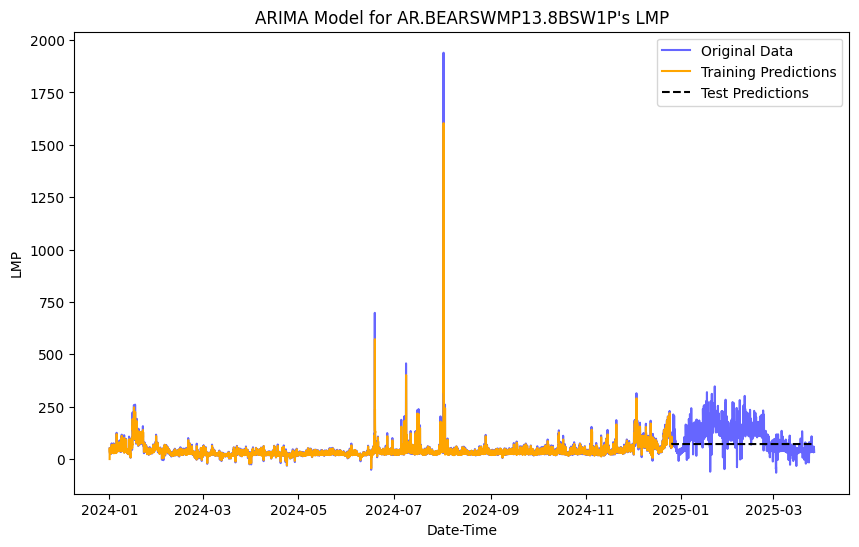

In [8]:
training_predictions = model_fit.fittedvalues

# forecasted data on test set
forecast = model_fit.forecast(steps=len(test_data))

test_data['forecast'] = forecast
test_preds = model_fit.forecast(steps=len(test_data))

# plot
plt.figure(figsize=(10,6))
plt.plot(lmp, label="Original Data", color="blue", alpha=0.6)
plt.plot(train_data.index, training_predictions, label="Training Predictions", color="orange")
plt.plot(test_data.index, test_data['forecast'], label="Test Predictions", color="black", linestyle="dashed")
plt.xlabel("Date-Time")
plt.ylabel("LMP")
plt.title("ARIMA Model for AR.BEARSWMP13.8BSW1P's LMP")
plt.legend()
plt.show()

The lookback is only 5 hrs, so once we predict for days in the future the model is going to just become the average of the data. Instead, use a 24hr rolling lookback, where we predict 24hrs out, then add those 24hrs back to the dataset.

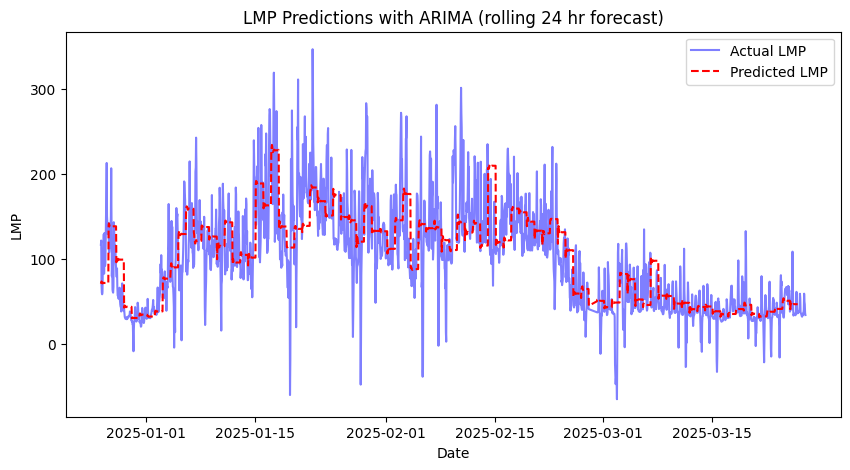

In [9]:
# train and test data, using 80% of the data initially
train_size = int(0.8 * len(lmp))
train_data = lmp.iloc[:train_size]
test_data = lmp.iloc[train_size:]

y_train = train_data['lmp'].values
y_test = test_data['lmp'].values

predictions = []

# start with the training data & define the prediction period, fiddle around with the period to see best
history = list(y_train)
forecast_period = 24

for t in range(0, len(y_test) - forecast_period, forecast_period):
    # fit the ARIMA
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    
    # forecast
    forecast = model_fit.forecast(steps=forecast_period)
    predictions.extend(forecast)

    # add actuals to the history
    history.extend(y_test[t:t+forecast_period])

# trim predictions for plotting
predictions = predictions[:len(y_test)]

# results
plt.figure(figsize=(10, 5))
plt.plot(test_data.index[:len(y_test)], y_test, label="Actual LMP", color='blue', alpha=0.5)
plt.plot(test_data.index[:len(predictions)], predictions, label="Predicted LMP", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("LMP")
plt.title(f"LMP Predictions with ARIMA (rolling {forecast_period} hr forecast)")
plt.legend()
plt.show()

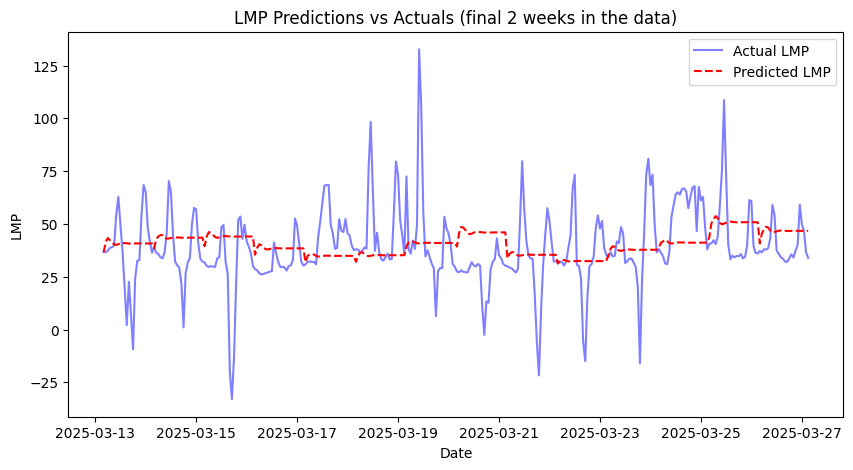

In [10]:
# look at last 2 weeks prediction
last_2_weeks = test_data.iloc[-24*14:]

# check the fit
plt.figure(figsize=(10, 5))
plt.plot(last_2_weeks.index, last_2_weeks['lmp'], label="Actual LMP", color='blue', alpha=0.5)
plt.plot(last_2_weeks.index, predictions[-24*14:], label="Predicted LMP", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("LMP")
plt.title("LMP Predictions vs Actuals (final 2 weeks in the data)")
plt.legend()
plt.show()

In [11]:
# check roots again
abs(model_fit.arroots)

array([1.40840847, 1.40840847, 1.58258578, 1.58258578, 1.92213307])

In [12]:
# calculate MAE and RMSE
y_test_vals = y_test[:len(predictions)]
# mae
mae = mean_absolute_error(y_test_vals, predictions)

# rmse
rmse = np.sqrt(mean_squared_error(y_test_vals, predictions))

# results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 29.62608356276053
Root Mean Squared Error (RMSE): 41.23695130646875


## AR()

In [13]:
# AR model
ar_model = AutoReg(train_data['lmp'], lags=5)  
ar_model_fit = ar_model.fit()
print(ar_model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                    lmp   No. Observations:                 8639
Model:                     AutoReg(5)   Log Likelihood              -39383.242
Method:               Conditional MLE   S.D. of innovations             23.161
Date:                Wed, 02 Apr 2025   AIC                          78780.484
Time:                        12:51:58   BIC                          78829.928
Sample:                    01-01-2024   HQIC                         78797.344
                         - 12-26-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1971      0.397     18.118      0.000       6.419       7.976
lmp.L1         0.8588      0.011     79.982      0.000       0.838       0.880
lmp.L2        -0.2210      0.014    -15.603      0.0

Stationary assumption seems to not be met for AR.2 and AR.3 where the roots have an abs value of less than 1.

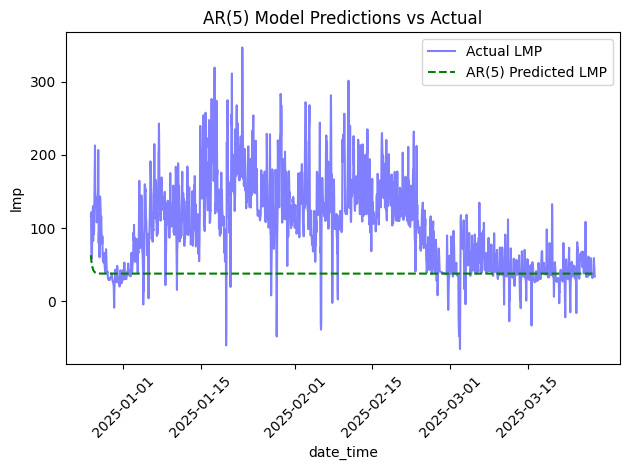

In [14]:
# ar predictions
ar_pred = ar_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
# arima forcast
forecast = model_fit.forecast(steps=len(test_data))
test_data['forecast'] = forecast

# dataframe for graph
ar_pred_data = pd.DataFrame({'date_time': test_data.index, 'ar_pred_lmp': ar_pred})
ar_pred_data.set_index('date_time', inplace=True)

# plot AR
plt.plot(test_data['lmp'], label='Actual LMP', color='blue', alpha=0.5)
plt.plot(ar_pred_data['ar_pred_lmp'], label='AR(5) Predicted LMP', color='green', linestyle='--')
plt.xlabel('date_time')
plt.ylabel('lmp')
plt.legend()
plt.title('AR(5) Model Predictions vs Actual')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


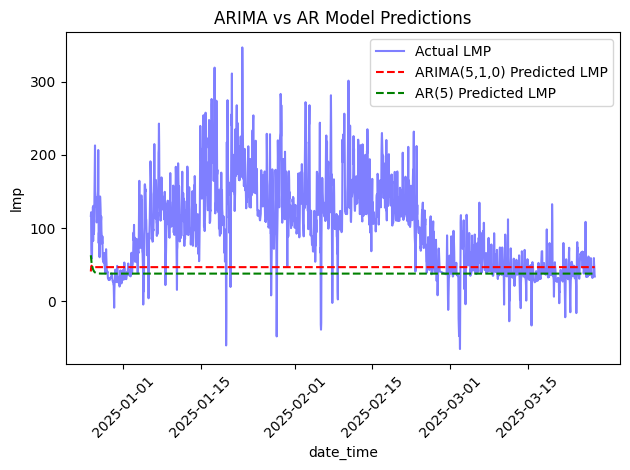

In [15]:
# show AR vs ARIMA
plt.plot(test_data['lmp'], label='Actual LMP', color='blue', alpha=0.5)
plt.plot(test_data['forecast'], label='ARIMA(5,1,0) Predicted LMP', color='red', linestyle='--')
plt.plot(ar_pred_data['ar_pred_lmp'], label='AR(5) Predicted LMP', color='green', linestyle='--')
plt.xlabel('date_time')
plt.ylabel('lmp')
plt.legend()
plt.title('ARIMA vs AR Model Predictions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
# MAE and MSE
arima_mse = mean_squared_error(test_data['lmp'], test_data['forecast'])
arima_mae = mean_absolute_error(test_data['lmp'], test_data['forecast'])
ar_mse = mean_squared_error(test_data['lmp'], ar_pred_data['ar_pred_lmp'])
ar_mae = mean_absolute_error(test_data['lmp'], ar_pred_data['ar_pred_lmp'])

arima_rmse = np.sqrt(arima_mse)
ar_rmse = np.sqrt(ar_mse)

print("ARIMA MSE:", arima_mse)
print("ARIMA RMSE:", arima_rmse)
print("ARIMA MAE:", arima_mae)
print("AR MSE:", ar_mse)
print("AR RMSE:", ar_rmse)
print("AR MAE:", ar_mae)

ARIMA MSE: 6359.958307424571
ARIMA RMSE: 79.74934675233754
ARIMA MAE: 60.88295662599574
AR MSE: 7356.540484630549
AR RMSE: 85.77027739625511
AR MAE: 65.47528010067808


now try rolling forecast with the AR model to compare to rolling ARIMA

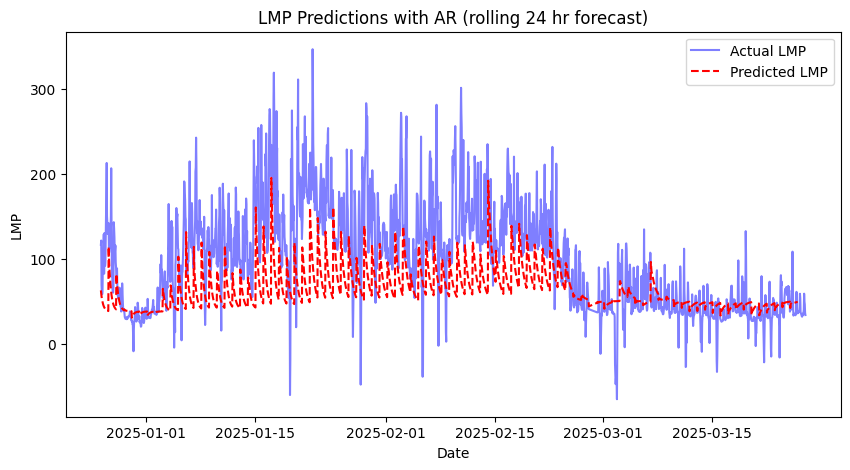

In [17]:
# train and test data, using 80% of the data initially
train_size = int(0.8 * len(lmp))
train_data = lmp.iloc[:train_size]
test_data = lmp.iloc[train_size:]

y_train = train_data['lmp'].values
y_test = test_data['lmp'].values

predictions = []

# start with the training data & define the prediction period, fiddle around with the period to see best
history = list(y_train)
forecast_period = 24

for t in range(0, len(y_test) - forecast_period, forecast_period):
    # fit the AR model
    model = AutoReg(history, lags=5)
    model_fit = model.fit()
    
    # forecast
    # start of the predictions
    start = len(history)
    # end of the preds
    end = start + forecast_period -1 
    forecast = model_fit.predict(start=start, end=end)
    predictions.extend(forecast)

    # add actuals to the history
    history.extend(y_test[t:t+forecast_period])

# trim predictions for plotting
predictions = predictions[:len(y_test)]

# results
plt.figure(figsize=(10, 5))
plt.plot(test_data.index[:len(y_test)], y_test, label="Actual LMP", color='blue', alpha=0.5)
plt.plot(test_data.index[:len(predictions)], predictions, label="Predicted LMP", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("LMP")
plt.title(f"LMP Predictions with AR (rolling {forecast_period} hr forecast)")
plt.legend()
plt.show()

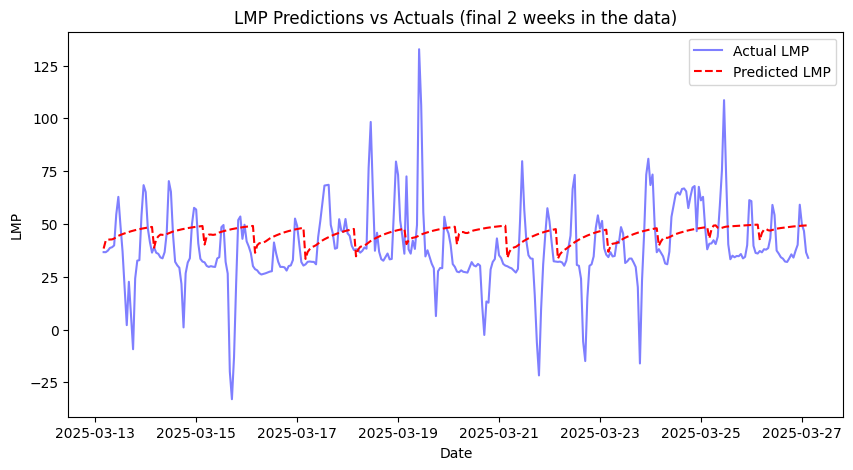

In [18]:
# look at last 2 weeks prediction
last_2_weeks = test_data.iloc[-24*14:]

# check the fit
plt.figure(figsize=(10, 5))
plt.plot(last_2_weeks.index, last_2_weeks['lmp'], label="Actual LMP", color='blue', alpha=0.5)
plt.plot(last_2_weeks.index, predictions[-24*14:], label="Predicted LMP", color='red', linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("LMP")
plt.title("LMP Predictions vs Actuals (final 2 weeks in the data)")
plt.legend()
plt.show()

In [19]:
# calculate MAE and RMSE
y_test_vals = y_test[:len(predictions)]
# mae
mae = mean_absolute_error(y_test_vals, predictions)

# rmse
rmse = np.sqrt(mean_squared_error(y_test_vals, predictions))

# results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 45.25747465677037
Root Mean Squared Error (RMSE): 64.05575290207459


In [20]:
# check roots
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                10751
Model:                     AutoReg(5)   Log Likelihood              -49353.664
Method:               Conditional MLE   S.D. of innovations             23.898
Date:                Wed, 02 Apr 2025   AIC                          98721.328
Time:                        12:52:00   BIC                          98772.304
Sample:                             5   HQIC                         98738.522
                                10751                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9757      0.348     14.281      0.000       4.293       5.659
y.L1           0.9135      0.010     95.072      0.000       0.895       0.932
y.L2          -0.2035      0.013    -15.610      0.0

stationary assumption not met for all of the roots